In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
#from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
#cr_cp = pm.df('cr_cp')
#fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()


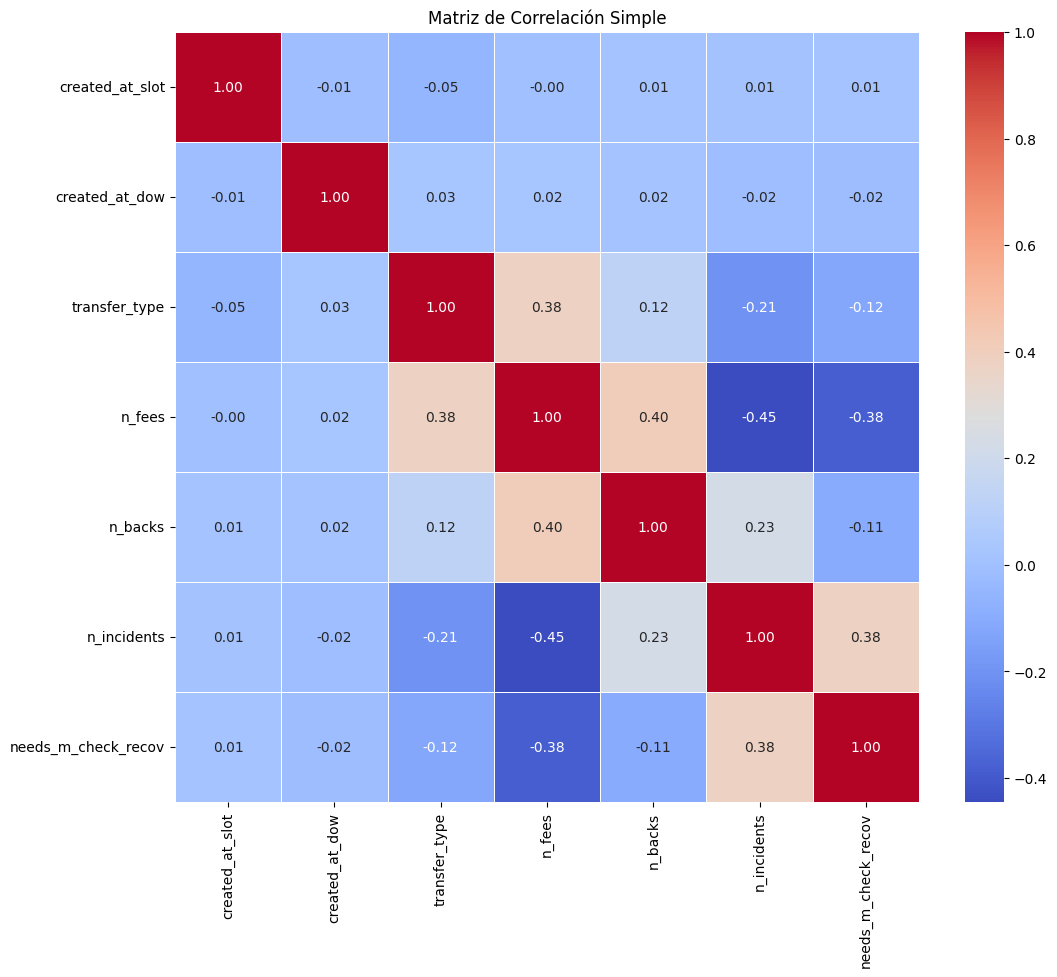

In [5]:
# Lista de columnas que deseas seleccionar del df_jo para el MODELO
columnas_deseadas = ['created_at_slot', 'created_at_dow' ,'transfer_type', 'n_fees', 'n_backs','n_incidents', 'needs_m_check_recov']

# Crear un nuevo DataFrame solamente con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl = df_simpl.copy()
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [8]:
# Modelo de REGRESIÓN LOGÍSTICA 

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['needs_m_check_recov'])  # Elimina la columna objetivo
y = df_simpl['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

#print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")



Coeficientes del modelo de regresión logística (ordenados por magnitud):
n_incidents: 0.5872
transfer_type: 0.3938
n_fees: -0.2781
n_backs: -0.1716
created_at_dow: -0.0115
created_at_slot: 0.0024


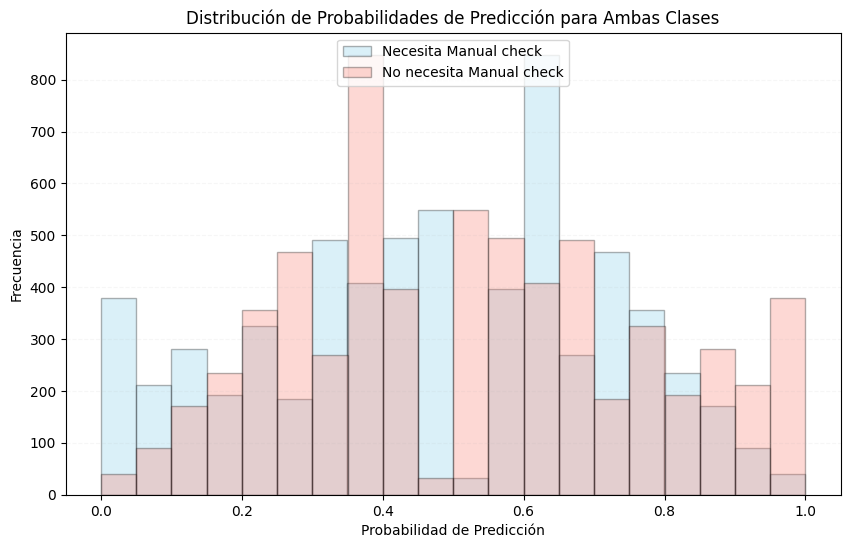

In [9]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [13]:
# Generamos Df para comparar realidad vs predicción

# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(10)

,needs_m_check_recov,prediccion,0,1
0,1,1,0.430271,0.569729
1,0,1,0.488420,0.511580
2,1,0,0.743346,0.256654
3,1,1,0.138725,0.861275
4,1,1,0.148928,0.851072
5,1,1,0.197224,0.802776
6,0,0,0.606029,0.393971
7,1,1,0.000946,0.999054
8,1,1,0.019980,0.980020
9,0,1,0.387832,0.612168


Text(70.5815972222222, 0.5, 'Realidad')

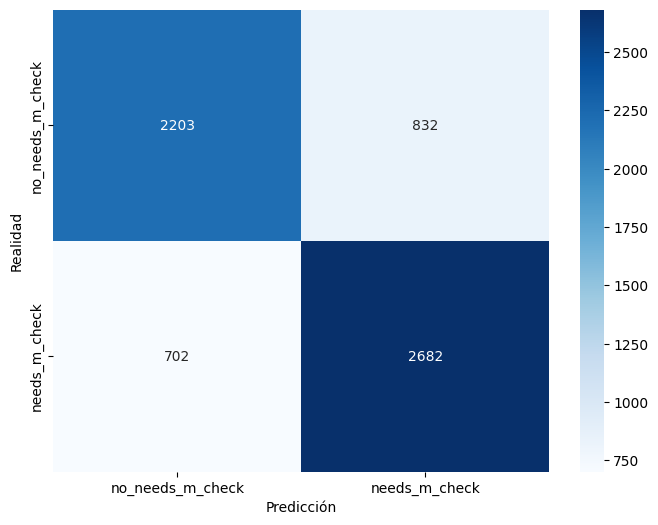

In [14]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")